In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import emcee
%matplotlib inline

In [2]:
A=np.loadtxt('prueba8_021_000_stars.pv')

In [3]:
# Estos son los datos que usamos
sizei=200000
sizef=400000
#sizef=sizei+1000
xs=A[sizei:sizef,0]
ys=A[sizei:sizef,1]
zs=A[sizei:sizef,2]
data=np.vstack((xs,ys,zs)).T

In [5]:
# Para el prior
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_proj=pca.fit_transform(data)
print(pca.explained_variance_)
print(pca.components_)

[ 35.82981879  22.29875623]
[[ 0.21539389 -0.00839967  0.97649113]
 [-0.94391472  0.25447599  0.21039718]]


In [6]:
def rot(VEC,angle):
    A=VEC[0]*np.cos(angle)-VEC[1]*np.sin(angle)
    B=VEC[0]*np.sin(angle)+VEC[1]*np.cos(angle)
    return np.array([A,B])

In [8]:
vector=np.cross(pca.components_[0],pca.components_[1])

In [170]:
vector

array([-0.25026081, -0.96704261,  0.046884  ])

In [9]:
theta=np.pi/4.
xymin=rot(vector[0:2],theta)
xymax=rot(vector[0:2],-theta)
xy=np.vstack((xymin,xymax))
xmin,xmax=np.sort(xy[:,0])
ymin,ymax=np.sort(xy[:,1])

In [10]:
yzmin=rot(vector[1:3],theta)
yzmax=rot(vector[1:3],-theta)
yz=np.vstack((yzmin,yzmax))
ymin2,ymax2=np.sort(yz[:,0])
zmin,zmax=np.sort(yz[:,1])

In [11]:
vector2=np.array([vector[2],vector[0]])
zxmin=rot(vector2,theta)
zxmax=rot(vector2,-theta)
zx=np.vstack((zxmin,zxmax))
zmin2,zmax2=np.sort(zx[:,0])
xmin2,xmax2=np.sort(zx[:,1])

In [41]:
# valores plausibles (alrededor de 45 grados) para los n,m,l en la ecuación nx+my+lz+d=0
ni=np.min(xmin,xmin2)
nf=np.max(xmax,xmax2)
mi=np.min(ymin,ymin2)
mf=np.max(ymax,ymax2)
li=np.min(zmin,zmin2)
lf=np.max(zmax,zmax2)

In [73]:
mi,mf,li,lf

(-0.86076350650255384,
 -0.50684127382855837,
 -0.65065039914486011,
 0.71695438118625188)

In [21]:
dataav=data-np.mean(data,axis=0)

In [57]:
# la distancia máxima desde el centro a lo largo del vector normal
di=-np.linalg.norm(dataav[np.argmax(np.abs(np.dot(dataav,vector)))])
df=-di

In [158]:
def lnprior(params,mi,mf,li,lf,di,df):
    if 1-params[0]**2-params[1]**2<0.:
        return -np.inf    
    if mi < params[0] < mf and li < params[1] < lf and di < params[2] < df:
        return 0.0
    return -np.inf

In [182]:
# prior de cono
def lnprior(params,theta,vector):
    if 1-params[0]**2-params[1]**2<0.:
        return -np.inf    
    n=-np.sqrt(1-params[0]**2-params[1]**2)
    normal=np.append([n],params[0:2])
    if 1. > np.dot(normal,vector) > np.cos(theta) and di < params[2] < df:
        return 0.0
    return -np.inf

In [183]:
lnprior(parguess,np.pi/4,vector)

-inf

In [176]:
parguess

array([-0.96704261,  0.046884  ,  0.        ])

In [177]:
vector

array([-0.25026081, -0.96704261,  0.046884  ])

In [184]:
n=-np.sqrt(1-parguess[0]**2-parguess[1]**2)
normal=np.append([n],params[0:2])
np.dot(normal,vector)


0.85531879177269832

In [174]:
np.dot(vector,vector)

1.0000000000000002

In [169]:
#parguess esta por fuera de mi y mf. npi
parguess

array([-0.96704261,  0.046884  ,  0.        ])

$$D=\frac{a\,x_0+b\,y_0+c\,z_0+d}{\sqrt{a^2+b^2+c^2}}$$

In [84]:
def distances(data,params):
    if 1-params[0]**2-params[1]**2<0.:
        return np.inf
    n=np.sqrt(1-params[0]**2-params[1]**2)
    normal=np.append([n],params[0:2])
    d=np.dot(data,normal)+params[2]
#    d=(np.dot(data,normal))/np.linalg.norm(params)
    return d

In [159]:
def lnlike(data,params):
    n=np.sqrt(1-params[0]**2-params[1]**2)
    normal=np.append([n],params[0:2])
    d=np.dot(data,normal)+params[2]
    inv_sigma2=1/1000.
    return -0.5*(np.sum(d**2*inv_sigma2-np.log(inv_sigma2)))

In [160]:
def lnprob(params,mi,mf,li,lf,di,df,data):
    lp = lnprior(params,mi,mf,li,lf,di,df)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(data,params)

In [80]:
params=np.array([-0.85076351, -0.6406504 ,  0.        ])

In [86]:
distances(dataav,params)

inf

In [85]:
lnprob(params,mi,mf,li,lf,di,df,dataav)

-inf

In [120]:
parguess=np.array([vector[1],vector[2],0.])
parguess

array([-0.96704261,  0.046884  ,  0.        ])

In [165]:
ndim, nwalkers = 3, 100
pos = [parguess + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [166]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mi,mf,li,lf,di,df,dataav))

In [167]:
sampler.run_mcmc(pos, 500)

(array([[ -9.67060073e-01,   4.68732532e-02,  -2.36902751e-05],
        [ -9.67043336e-01,   4.68733327e-02,  -1.91797555e-06],
        [ -9.67054977e-01,   4.68819525e-02,  -1.47278148e-05],
        [ -9.67036928e-01,   4.68948950e-02,  -5.64280642e-07],
        [ -9.67049585e-01,   4.68787682e-02,  -7.05996566e-06],
        [ -9.67041699e-01,   4.68795007e-02,  -7.90929394e-06],
        [ -9.67026806e-01,   4.68806447e-02,  -8.89382586e-07],
        [ -9.67037491e-01,   4.68982123e-02,   1.25348195e-06],
        [ -9.67040674e-01,   4.68920468e-02,  -3.68059361e-06],
        [ -9.67045586e-01,   4.68995604e-02,   2.97511344e-06],
        [ -9.67033707e-01,   4.68682162e-02,   2.19431677e-05],
        [ -9.67039402e-01,   4.68870691e-02,  -1.79777987e-05],
        [ -9.67064649e-01,   4.68834178e-02,  -2.28474891e-06],
        [ -9.67056042e-01,   4.68851902e-02,  -8.45861144e-06],
        [ -9.67043934e-01,   4.68904241e-02,   3.29142547e-06],
        [ -9.67040883e-01,   4.68972073e

In [114]:
sampler.chain

array([[[ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05],
        [ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05],
        [ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05],
        ..., 
        [ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05],
        [ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05],
        [ -9.67261348e-01,   4.68083960e-02,   4.98238331e-05]],

       [[ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05],
        [ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05],
        [ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05],
        ..., 
        [ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05],
        [ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05],
        [ -9.67107307e-01,   4.67320495e-02,   4.40980644e-05]],

       [[ -9.66971300e-01,   4.70369844e-02,   9.15726191e-06],
        [ -9.66971300e-01,   4.70369844e-02,   9.15726191e-06],
        [ -9.66971300e-01,   4.70369844e-02,   9.15726191e-06],
        

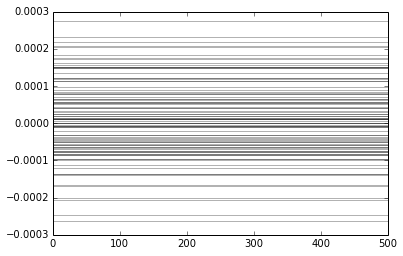

In [164]:
res=plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)

In [119]:
sampler.run_mcmc

<bound method EnsembleSampler.run_mcmc of <emcee.ensemble.EnsembleSampler object at 0x1076c63d0>>

In [69]:
vector[-1]

0.046883995321139141